In [5]:
from __future__ import unicode_literals
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import hypergeom
from scipy.spatial import distance
from collections import OrderedDict

import pickle
import pandas as pd
import numpy as np
import nltk as nk
import untangle
import seaborn as sns
import operator
import string 
import math
import random
import matplotlib
from gensim import corpora, models, similarities
from nltk import wordnet as wn

%matplotlib inline

nk.download('punkt')
nk.download('stopwords')
nk.download('wordnet')
nk.download('treebank')
nk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/andres/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/andres/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package treebank to /home/andres/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/andres/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Asociación de palabras

# bigramcollocationfinder.from_words

#### 1. Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccionario (DOCNO :TEXT).


In [21]:
corpus_ap = {}
obj = untangle.parse('ap/ap.txt')
for i in range(len(obj.root.DOC)):
    documento = obj.root.DOC[i]
    corpus_ap[documento.DOCNO.cdata.strip()] = documento.TEXT.cdata.strip()

### 2. Calcular el tamaño del vocabulario

#### Pasos de filtrado

1. Tokenizamos oraciones
2. Para cada oración realizamos una tokenización de palabras básica (separamos por espacios)
3. Computamos el POS tag de cada palabra
4. Usando el POS tag lematizamos cada palabra
5. Para cada palabra lematizada aumentamos en 1 la cantidad de veces que aparece

In [22]:
def clean_chars(word):
    replaceable = [",", ".", "-", "_", "`", ":", ";", "!", "?", "`", "'"]
    for token in replaceable:
        word = word.replace(token, " ")
    return word.strip()

stopw = set(nk.corpus.stopwords.words("english"))


documents = []

for (docno, text) in corpus_ap.items():
    tokens = nk.sent_tokenize(text.lower())
    document = ""
    for sent in tokens:
        document += sent
    documents.append(document)

len(documents)
    
words_by_doc = [[clean_chars(w) for w in d.split() if len(clean_chars(w)) > 1 or clean_chars(w).isalpha()] 
                  for d in documents]
        
words_by_doc = [[w for w in sent if w not in stopw and len(w) > 1] for sent in words_by_doc]

In [23]:
word_semantic = nk.tag.pos_tag_sents(words_by_doc)

In [24]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return nk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nk.corpus.wordnet.ADV
    else:
        return nk.corpus.wordnet.NOUN

lemmatizer = nk.WordNetLemmatizer()

word_count = {}

clean_texts = []

for document in word_semantic:
    text = ""
    for (word, tag) in document:
        lemmatized = lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        word = lemmatized.split()[0]
        if not word[0].isalpha():
            continue
        elif word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
        text += " " + word
    clean_texts.append(text)
    
with open('word_count2.pickle', 'wb') as handle:
    pickle.dump(word_count, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('word_count2.pickle', 'rb') as handle:
    word_count = pickle.load(handle) 

word_count = [(x, y) for (x, y) in sorted(word_count.items(), key=operator.itemgetter(1), reverse=True)]

In [8]:
print "Tamaño del vocabulario: ", len(word_count), " palabras."

Tamaño del vocabulario:  29435  palabras.


#### 3. Para las 500 palabras con más apariciones, calcular el par más asociado según la medida presentada.

In [9]:
most_used = word_count[:500]

Para el cálculo utilizaremos una ventana de 5 palabras como indica el paper.

In [10]:
def get_close_words_flex(words, idx):
    close_izq = words[max(0, idx-10):idx]
    close_der = words[idx+1:min(len(words)-1,idx + 11)]
    i=0
    while i<len(close_izq):
        if words[idx]==close_izq[i]:
            close_izq=close_izq[i+6:]
            i=0
        i+=1
    i=0
    while i<len(close_der):
        if words[idx]==close_der[i]:
            close_der=close_der[:i]
            i=0
        i+=1
    while (len(close_izq)>5):
        close_izq = close_izq[1:]
    if len(close_der)>5:
        close_der = close_der[:5]
    return close_izq + close_der

def get_close_words(words, idx):
    return words[max(0, idx-5):idx] + words[idx+1:min(len(words)-1,idx + 6)]

window_size = 5

asociaciones = {}
for word,amt in most_used:
        asociaciones[word] = {}
for document in clean_texts:
    for (target, amt) in most_used:
        sdoc = document.split()
        for idx in range(len(sdoc)):
            if sdoc[idx] == target:
#                for pareja in get_close_words(sdoc, idx):
                for pareja in get_close_words_flex(sdoc, idx):
                    asociaciones[target][pareja] = \
                        asociaciones[target][pareja] + 1 if pareja in asociaciones[target] else 1

In [11]:
palabras_totales = sum([y for (x, y)  in word_count])
world_count_dict = dict(word_count)

def freq(x):
    return world_count_dict[x] / float(palabras_totales)

def info_mutua(x, y):       
    if y not in asociaciones[x]:
        return 0
    else:
        # print float(asociaciones[x][y])/palabras_totales, freq(x), freq(y)
        return (float(asociaciones[x][y])/palabras_totales) / (freq(x)*freq(y))

Al igual que en el paper citado, no tomamos en cuenta las duplas de palabras con muy pocas apariciones, ya que vuelven inestable la medición.

In [12]:
maximas_relacionadas = {}
for palabra_estrella, cant in most_used:
    maximas_relacionadas[palabra_estrella] = ('', 0)
    palabras_relacionadas = asociaciones[palabra_estrella].keys()
    #print len(palabras_relacionadas)
    for palabra_relacionada in palabras_relacionadas:
        i_mutua = info_mutua(palabra_estrella, palabra_relacionada)
        # ahora revisamos que aparezca una cantidad mínima de 5 veces esta dupla
        valida = asociaciones[palabra_estrella][palabra_relacionada]>5
        if maximas_relacionadas[palabra_estrella][1] < i_mutua and valida:
            maximas_relacionadas[palabra_estrella] = (palabra_relacionada, i_mutua)
maximas_relacionadas

{u'accord': (u'sources', 524.0467098533925),
 u'accuse': (u'conspire', 871.3316326530612),
 u'across': (u'shower', 487.9457142857143),
 u'act': (u'specie', 408.24143426294825),
 u'action': (u'disciplinary', 977.1322314049588),
 u'add': (u'anything', 87.00000000000001),
 u'administration': (u'aeronautics', 922.5864345738296),
 u'africa': (u'namibia', 1196.4745575221239),
 u'agency': (u'adn', 644.109375),
 u'ago': (u'year', 139.22964258204533),
 u'agree': (u'principle', 334.3963636363637),
 u'agreement': (u'tentative', 577.8304511278195),
 u'aid': (u'infected', 1117.9554239401496),
 u'air': (u'langley', 955.8638059701492),
 u'airline': (u'traveler', 698.6495454545455),
 u'allow': (u'constitution', 76.92645329195966),
 u'along': (u'creek', 323.75545023696685),
 u'already': (u'recession', 193.2883551307847),
 u'also': (u'prices', 55.62899022801303),
 u'america': (u'latin', 953.6739690721649),
 u'american': (u'telegraph', 378.75932172064876),
 u'among': (u'chip', 174.98053278688525),
 u'ana

## Información Léxica[2]
Bajar de Project Gutenberg el libro de Darwin ON THE ORIGIN OF SPECIES.

#### 1. Procesar el texto, tokenizando eliminando signos de puntuación.

In [13]:
tokenizer = nk.tokenize.RegexpTokenizer(r'\w+')
with open('darwin.txt', 'r') as darwintexto:
    data= tokenizer.tokenize(darwintexto.read())

In [14]:
data = [d.lower() for d in data]

#### 2. Siguiendo el artículo de la sección, calcular la autocorrelación para estimar la distribución de la palabra a lo largo del texto.

In [15]:
def wordDensity(palabra):
    positions = [i for i in range(0, len(data)) if data[i] == palabra]
    return (len(positions), positions)

def wordDist(word):
    den = wordDensity(word)[0]
    dato = [int(w == word)/float(den) for w in data]
    dato = gaussian_filter(dato, sigma=50)
    return map(lambda x : 1e3*x, dato)
        
def autocorrelacion(word, tau):
    distribucion = wordDist(word)
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    
    for i in range(0, len(distribucion) - tau):
        t1 += distribucion[i]*distribucion[(i+tau)]
        t2 += distribucion[i]
        t3 += distribucion[(i+tau)]
        t4 += np.power(distribucion[i],2)
        
    total = float(len(data))
    
    t1 = t1 / total
    t2 = t2 / total
    t3 = t3 / total
    t4 = t4 / total
    return (t1 - t2*t3)/ (t4 - np.power(t1,2)) 

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


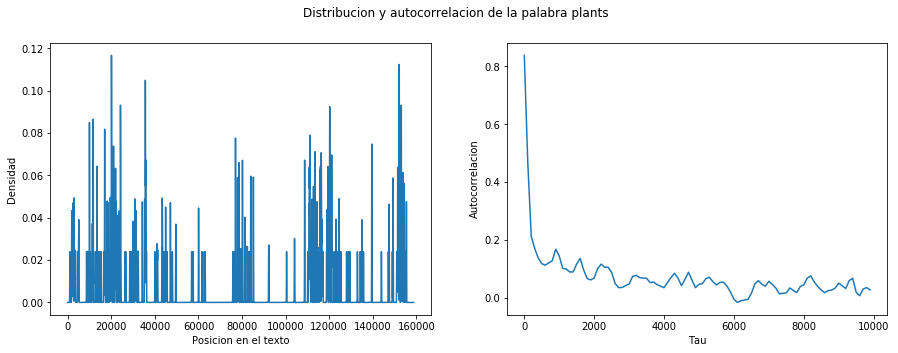

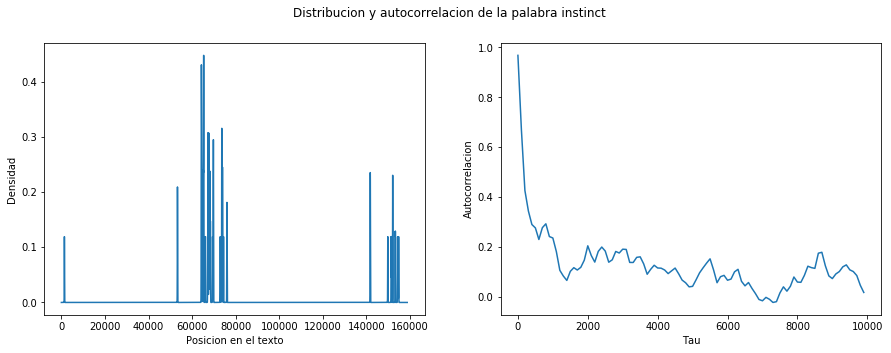

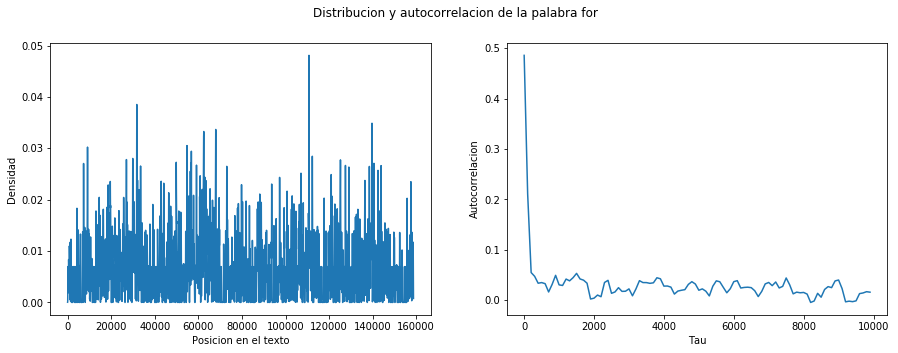

In [16]:
laspalabra = ['plants', 'instinct', 'for']

for lapalabra in laspalabra:
    taus = []
    autocor = []
    for tau in range(0, 10000, 100):
        taus.append(tau)
        autocor.append(autocorrelacion(lapalabra, tau))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("Distribucion y autocorrelacion de la palabra {}".format(lapalabra))
    axes[0].plot(wordDist(lapalabra))
    axes[1].plot(taus, autocor)
    
    axes[0].set_xlabel("Posicion en el texto")
    axes[0].set_ylabel("Densidad")
    
    axes[1].set_xlabel("Tau")
    axes[1].set_ylabel("Autocorrelacion")
    
    fig.show()

#### 3 y 4.  Calcular la entropía de una selección de 100 palabras que abarquen el rango de frecuencia de aparición en el libro, es decir elegir palabras que son muy frecuentes y otras de baja frecuencia. Calcular la entropía de las palabras seleccionadas anteriormente, randomizando su posición en el texto. Comparar con los resultados del punto anterior.

In [17]:
def entropia(word, text, n_particiones=64):
    entropia = 0
    total = freq[word]
    for i in range(n_particiones):
        l = i * len(data) / n_particiones
        r = l + len(data) / n_particiones
        
        apariciones = sum(map(lambda w: w == word, text[l:r+1]))
        if apariciones == 0:
            continue
        else:
            entropia += (apariciones/float(total)) * np.log2(apariciones/float(total))
    return -entropia

def entropia_analitica(word, text, n_particiones=64):
    n = sum(map(lambda w: w == word, text))
    N = len(data)
    
    limite = min(n, N/n_particiones)
    entropia = 0
    
    for m in range(1, limite+1):
        p = hypergeom(N, n, N/n_particiones)
        if n == 0:
            continue
        else:
            entropia += p.pmf(m) * (m / float(n)) * np.log2(m / float(n))

    return -n_particiones * entropia

Dado que la gran mayoría de las palabras aparece muy pocas veces, nos aseguramos de agarrar las palabras que creemos aparecen muchas y moderadas veces, y la otra mitad se elige al azar entre el resto de las palabras.

In [18]:
fdist = nk.FreqDist(data)
freq = OrderedDict(sorted(fdist.items(), key=lambda x: x[1], reverse=True))

In [19]:
palabras_por_freq = list(freq)

sample = palabras_por_freq[0:50]
sample += [palabras_por_freq[i] for i in sorted(random.sample(range(51, len(palabras_por_freq)+1),50))]

In [20]:
randwin = np.copy(data)
np.random.shuffle(randwin)

entropias = []
entropias_random = []
entropias_analiticas = []

for word in sample:
    entropias.append(entropia(word, data, 64))
    entropias_random.append(entropia(word, randwin, 64))
    entropias_analiticas.append(entropia_analitica(word, data, 64))

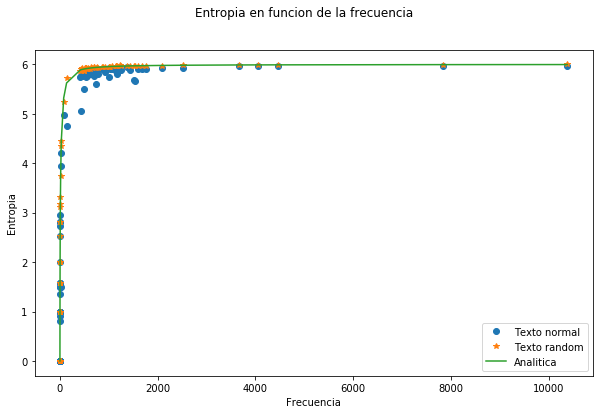

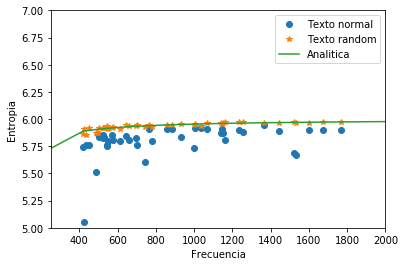

In [21]:
frecuencias = map(lambda x: freq[x], sample) 

plt.clf()
fig = plt.figure(figsize=(10, 6))
plt.plot(frecuencias, entropias, 'o', label="Texto normal")
plt.plot(frecuencias, entropias_random, '*', label="Texto random")
plt.plot(frecuencias, entropias_analiticas, label="Analitica")

fig.suptitle("Entropia en funcion de la frecuencia")
plt.legend(loc="best")
plt.xlabel("Frecuencia")
plt.ylabel("Entropia")
plt.show()


plt.plot(frecuencias, entropias, 'o', label="Texto normal")
plt.plot(frecuencias, entropias_random, '*', label="Texto random")
plt.plot(frecuencias, entropias_analiticas, label="Analitica")

plt.legend(loc="best")
plt.xlabel("Frecuencia")
plt.ylabel("Entropia")
plt.xlim(250, 2000)
plt.ylim(5,7)
plt.show()

La entropía análitica la calculamos de acuerdo a lo que aparece en el Apéndice C del paper _"Towards the quantification of the semantic information encoded in written language."_ - Marcelo A Montemurro and Dami´an H Zanette. .

In [22]:
print "Entropía media en el texto: {}\nEntropía media con texto randomizado: {}".format(np.mean(entropias), np.mean(entropias_random))

Entropía media en el texto: 3.43348368232
Entropía media con texto randomizado: 3.60801423645


En el gráfico observamos que la entropía de las palabras seleccionadas es en promedio más baja para el texto normal que para el randomizado. Como indica en el paper, esto se debe a la estructura de la distribución de las palabras que existe en el texto original, donde la aparición de cada palabra es intencional con el objetivo comunicar algo. Por otro lado el texto randomizado no tiene ningún tipo de estructura.

El segundo gráfico que es un acercamiento del de arriba lo utilizamos para observar el segundo punto que remarcan. Para palabras con la misma frecuencia se ve que en el texto ordenado la entropía fluctúa mucho más que en el randomizado. Esto es consecuencia de la intencionalidad con la que el autor pone cada palabra en su texto, condicionado por reglas semánticas y sintácticas inherentes al lenguaje, además de por los temas que trate cada parte del texto en particular.

Toda esta información se pierde al randomizar el texto, por lo que la entropía de todas las palabras se eleva perdiendo estas fluctuaciones.

## Word embeddings, distancia semántica y WordNet

#### 1. Utilizando el test WordSim353, comparar el rendimiento entre LSA[3] y Word2Vec2

Compararemos la similaridad entre palabras según humanos (WordSim353) con la similaridad para las técnicas Word2Vec y LSA.

Word2Vec es un método que a través del uso de redes neuronales transforma cada palabra a un vector de números reales. La similaridad entre dos palabras estará dada por la distancia entre estos dos vectores.

Latent semantic analysis (LSA) es una técnica para analizar la relación entre conjuntos de documentos y los términos que contienen.

En ambos casos utilizaremos como el dataset del ejercicio 1.

In [81]:
print "Datos de WordSim353"
wordsim_df = pd.read_csv("wordsim353/combined.csv")
wordsim_df.head(10)

Datos de WordSim353


,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62
5,computer,internet,7.58
6,plane,car,5.77
7,train,car,6.31
8,telephone,communication,7.50
9,television,radio,6.77


In [82]:
texts_as_wordlist = [clean_text.split() for clean_text in clean_texts]
word2vec_model = models.Word2Vec(sentences=texts_as_wordlist, window=5, min_count=10, workers=4)
word2vec_model.save('word2vec_model.pk')

In [83]:
word2vec_model = models.Word2Vec.load('word2vec_model.pk')
print "Probando formas de medir similaridad"
print word2vec_model.wv.similarity('shower', 'flood')
print word2vec_model.wv.most_similar('weather')
print word2vec_model.wv.most_similar_cosmul('weather')
print word2vec_model.wv.most_similar_to_given('weather', ['cold', 'rain', 'area', 'office', 'sun', 'cloud'])


Probando formas de medir similaridad
0.957439175186
[(u'dip', 0.9787805080413818), (u'gas', 0.9777778387069702), (u'overnight', 0.97774738073349), (u'aluminum', 0.9775444865226746), (u'pump', 0.9771118760108948), (u'locally', 0.9769812822341919), (u'slip', 0.9769667387008667), (u'meat', 0.9760500192642212), (u'gauge', 0.9758710265159607), (u'mostly', 0.9758517742156982)]
[(u'dip', 0.9893893003463745), (u'gas', 0.9888879656791687), (u'overnight', 0.988872766494751), (u'aluminum', 0.9887713193893433), (u'pump', 0.9885549545288086), (u'locally', 0.9884897470474243), (u'slip', 0.9884824752807617), (u'meat', 0.9880240559577942), (u'gauge', 0.9879345893859863), (u'mostly', 0.9879249334335327)]
rain


In [84]:
def get_word2vec_sim(row):
    try:
        result = word2vec_model.wv.similarity(row[wordsim_df.columns[0]], row[wordsim_df.columns[1]])
    except KeyError:
        # Si la palabra no esta en el texto
        result = np.nan
    finally:
        return result
wordsim_df["word2vec"] = wordsim_df.apply(lambda row: get_word2vec_sim(row), axis=1)

In [85]:
# limpio los que no estan en word2vec
wordsim_df = wordsim_df[wordsim_df["word2vec"] > 0]
# normalizo valores al rango 0- 10
wordsim_df["word2vec"] = wordsim_df.apply(lambda row: row["word2vec"]*10, axis=1)

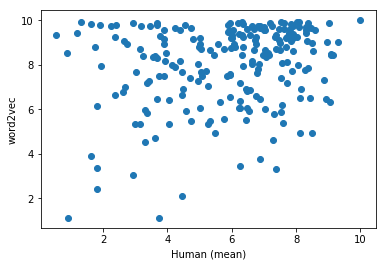

In [86]:
plt.plot(wordsim_df['Human (mean)'], wordsim_df['word2vec'], 'o')
plt.xlabel("Human (mean)")
plt.ylabel("word2vec")
plt.show()

In [87]:
dictionary = corpora.Dictionary(texts_as_wordlist)
corpora.MmCorpus.serialize('corpus.crp', (dictionary.doc2bow(text) for text in texts_as_wordlist))
corpus = corpora.MmCorpus('corpus.crp')

lsi = models.LsiModel(corpus, id2word = dictionary, num_topics = 400)

In [88]:
lsi.print_topics(5)

[(0,
  u'0.650*"say" + 0.197*"said" + 0.166*"would" + 0.141*"year" + 0.122*"state" + 0.118*"u" + 0.108*"new" + 0.105*"percent" + 0.096*"people" + 0.094*"one"'),
 (1,
  u'0.600*"percent" + 0.244*"year" + -0.242*"say" + 0.192*"billion" + 0.191*"million" + 0.170*"price" + 0.150*"rise" + 0.146*"rate" + 0.126*"market" + 0.111*"increase"'),
 (2,
  u'0.338*"soviet" + -0.299*"say" + 0.244*"bush" + 0.220*"president" + -0.191*"said" + 0.186*"would" + 0.176*"party" + 0.160*"u" + 0.154*"gorbachev" + 0.132*"state"'),
 (3,
  u'-0.295*"cent" + -0.266*"soviet" + 0.234*"bush" + -0.165*"dollar" + -0.165*"price" + -0.161*"market" + 0.154*"would" + 0.146*"percent" + 0.144*"year" + 0.144*"dukakis"'),
 (4,
  u'-0.405*"percent" + -0.275*"soviet" + 0.261*"cent" + 0.192*"bush" + 0.165*"new" + -0.163*"government" + 0.151*"market" + -0.145*"party" + 0.143*"stock" + 0.139*"dollar"')]

In [89]:
def lsi2vec(word):
    vec_bow = dictionary.doc2bow([word.lower()])
    return [val for idx, val in lsi[vec_bow]]

def lsi_word_dist(word1, word2):
    dist = distance.euclidean(lsi2vec(word1), lsi2vec(word2))
    return 1 - dist if dist > 0 else 1 

def get_lsi_sim(row):
    try:
        result = lsi_word_dist(row[wordsim_df.columns[0]], row[wordsim_df.columns[1]])
    except KeyError:
        # Si la palabra no esta en el texto
        result = np.nan
    finally:
        return result

wordsim_df["lsi"] = wordsim_df.apply(lambda row: get_lsi_sim(row), axis=1)

#normalizo al rango 0 - 10
wordsim_df["lsi"] = wordsim_df.apply(lambda row: (row["lsi"] * (10.0/wordsim_df["lsi"].quantile(.90))), axis=1)

# lo saturo en 10
wordsim_df["lsi"] = wordsim_df.apply(lambda row: (10 if row["lsi"]>=10 else max(0, row["lsi"])), axis=1)

maxs: 10.0 10.0 10.0


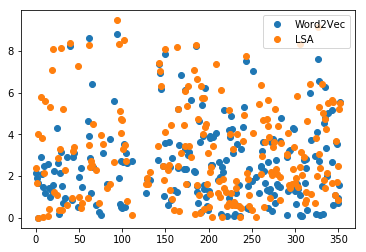

Distancias medias a medida humana
Word2vec:  2.62592079342
LSA:  3.17542302776


In [90]:
print "maxs:", wordsim_df["word2vec"].max(), wordsim_df["lsi"].max(), wordsim_df["Human (mean)"].max()

word2vec_diffs = wordsim_df.apply(lambda row: max(row["Human (mean)"] - row["word2vec"], row["word2vec"] - row["Human (mean)"]), axis=1)
lsa_diffs = wordsim_df.apply(lambda row: max(row["lsi"] - row["Human (mean)"], row["Human (mean)"] - row["lsi"]), axis=1)

plt.plot(word2vec_diffs, 'o', label='Word2Vec')
plt.plot(lsa_diffs, 'o', label='LSA')
plt.legend(loc='best')
plt.show()

print "Distancias medias a medida humana"
print "Word2vec: ", word2vec_diffs.mean()
print "LSA: ", lsa_diffs.mean()

#### 2. Comparar los distintos word embeddings con las medidas definidas en WordNet.

In [91]:
def get_path_similarity(row):
    word1 = wn.wordnet.synsets(row['Word 1'])
    word2 = wn.wordnet.synsets(row['Word 2'])
    return word1[0].path_similarity(word2[0])

def get_wup_similarity(row):
    word1 = wn.wordnet.synsets(row['Word 1'])
    word2 = wn.wordnet.synsets(row['Word 2'])
    return word1[0].wup_similarity(word2[0])

def get_lch_similarity(row):
    word1 = wn.wordnet.synsets(row['Word 1'])
    word2 = wn.wordnet.synsets(row['Word 2'])
    try:
        return word1[0].lch_similarity(word2[0])
    except Exception:
        return -1

wordsim_df["path_similarity"] = wordsim_df.apply(lambda row: get_path_similarity(row), axis=1)
wordsim_df["wup_similarity"] = wordsim_df.apply(lambda row: get_wup_similarity(row), axis=1)
wordsim_df["lch_similarity"] = wordsim_df.apply(lambda row: get_lch_similarity(row), axis=1)

wordsim_df.dropna()

,Word 1,Word 2,Human (mean),word2vec,lsi,path_similarity,wup_similarity,lch_similarity
0,love,sex,6.77,8.915904,9.173556,0.083333,0.153846,1.152680
1,tiger,cat,7.35,9.249126,9.026429,0.090909,0.545455,1.239691
2,tiger,tiger,10.00,10.000000,10.000000,1.000000,0.750000,3.637586
3,book,paper,7.46,9.130869,3.441225,0.076923,0.250000,1.072637
6,plane,car,5.77,8.687654,0.000000,0.111111,0.666667,1.440362
7,train,car,6.31,8.424265,2.474728,0.125000,0.666667,1.558145
8,telephone,communication,7.50,8.987615,7.530390,0.071429,0.133333,0.998529
9,television,radio,6.77,9.260997,4.638480,0.333333,0.900000,2.538974
11,drug,abuse,6.85,8.054183,1.248083,0.076923,0.142857,1.072637
14,doctor,nurse,7.00,9.572297,6.891993,0.250000,0.869565,2.251292


In [100]:
for col in ["path_similarity", "wup_similarity", "lch_similarity"]:
    M = wordsim_df[col].max()
    m = wordsim_df[col].min()
    wordsim_df[col] = wordsim_df[col].apply(lambda x: (10/(M - m)) * (x - m))
wordsim_df.dropna()

,Word 1,Word 2,Human (mean),word2vec,lsi,path_similarity,wup_similarity,lch_similarity
0,love,sex,6.77,8.915904,9.173556,0.350877,0.647773,4.641810
1,tiger,cat,7.35,9.249126,9.026429,0.430622,4.976077,4.829432
2,tiger,tiger,10.00,10.000000,10.000000,10.000000,7.236842,10.000000
3,book,paper,7.46,9.130869,3.441225,0.283401,1.710526,4.469215
6,plane,car,5.77,8.687654,0.000000,0.643275,6.315789,5.262137
7,train,car,6.31,8.424265,2.474728,0.789474,6.315789,5.516112
8,telephone,communication,7.50,8.987615,7.530390,0.225564,0.421053,4.309416
9,television,radio,6.77,9.260997,4.638480,2.982456,8.894737,7.631069
11,drug,abuse,6.85,8.054183,1.248083,0.283401,0.526316,4.469215
14,doctor,nurse,7.00,9.572297,6.891993,2.105263,8.558352,7.010742


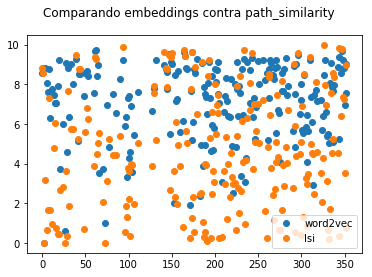

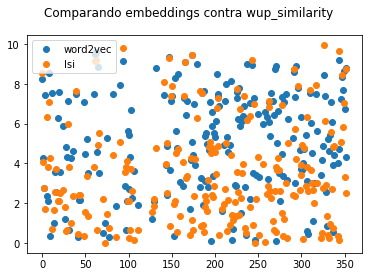

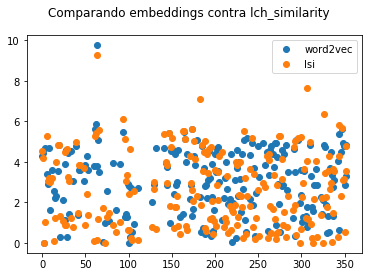

Distancia media de word2vec a path_similarity: 7.15777058066
Distancia media de lsi a path_similarity: 4.66425415033
Distancia media de word2vec a wup_similarity: 5.05655654156
Distancia media de lsi a wup_similarity: 3.48198876451
Distancia media de word2vec a lch_similarity: 3.05296435015
Distancia media de lsi a lch_similarity: 2.63590217638



In [99]:
res = ""
for col in ["path_similarity", "wup_similarity", "lch_similarity"]:
    for embedding in ["word2vec", "lsi"]:
        diffs = wordsim_df.apply(lambda row: abs(row[embedding] - row[col]), axis=1)
        plt.plot(diffs, 'o', label=embedding)
        res += "Distancia media de {} a {}: {}\n".format(embedding, col, np.mean(diffs))
    plt.suptitle("Comparando embeddings contra {}".format(col))    
    plt.legend(loc='best')
    plt.show()

print res